In this notebook, we'll go through the steps to train a CRNN (CNN+RNN) model for handwriting recognition. The model will be trained using the CTC(Connectionist Temporal Classification) loss.


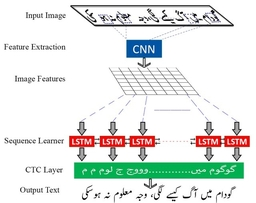

Lets start by importing the necessary libraries. I'll be using Keras for building our CRNN model.

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

import wandb

2024-05-15 12:26:43.815898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 12:26:44.722341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/py38_default/lib/python3.8/site-packages/cv2/../../lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-15 12:26:44.722481: W tensorflow/c

## Load and view data

In [3]:
train = pd.read_csv('handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('handwriting-recognition/written_name_validation_v2.csv')

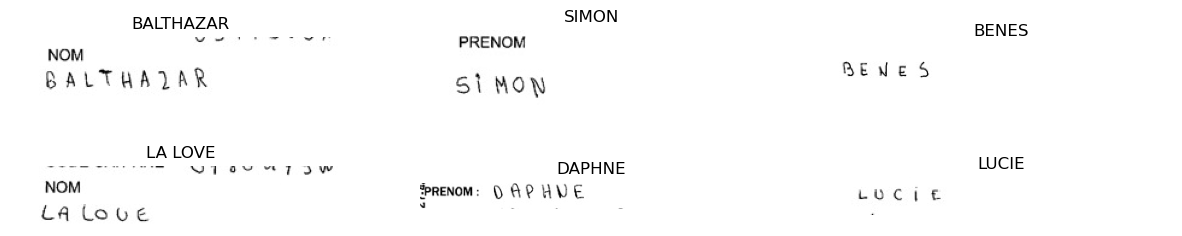

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [5]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [6]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

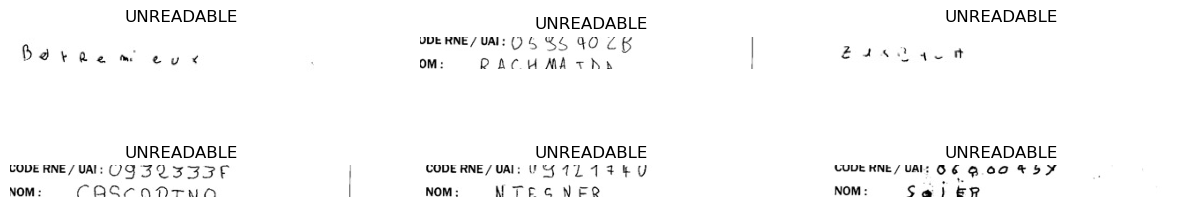

In [7]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [9]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

Reset the index and we are done with cleaning. 

In [10]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

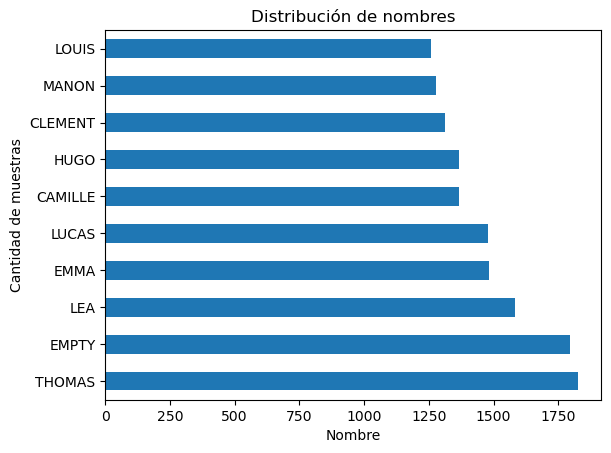

THOMAS     1825
EMPTY      1796
LEA        1582
EMMA       1482
LUCAS      1479
CAMILLE    1367
HUGO       1367
CLEMENT    1313
MANON      1277
LOUIS      1257
Name: IDENTITY, dtype: int64


In [11]:
name_counts = train['IDENTITY'].value_counts()

name_counts[:10].plot(kind='barh')
plt.title('Distribución de nombres')
plt.xlabel('Nombre')
plt.ylabel('Cantidad de muestras')
plt.show()

print(name_counts[:10])


In [12]:
print("Quantitat de noms:", train['IDENTITY'].shape[0])
print("Quantitat de noms diferents:", train['IDENTITY'].nunique())

Quantitat de noms: 330294
Quantitat de noms diferents: 100525


## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y). 
* The image is then normalized to range [0, 1]

In [13]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [14]:
train_size = 30000
valid_size= 3000

In [15]:
train_x = []

for i in range(train_size):
    img_dir = 'handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [16]:
valid_x = []

for i in range(valid_size):
    img_dir = 'handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [17]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [18]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [19]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss. 


In [20]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [21]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [22]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


## Building our model


In [23]:
from collections import Counter

all_text = ''.join(train['IDENTITY'])

letter_counts = Counter(all_text.upper())

for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' ":
    count = letter_counts[letter]

print(letter_counts.keys())
print(len(letter_counts.keys()))

dict_keys(['B', 'A', 'L', 'T', 'H', 'Z', 'R', 'S', 'I', 'M', 'O', 'N', 'E', ' ', 'V', 'D', 'P', 'U', 'C', 'Q', 'Y', 'X', 'J', 'F', 'G', 'W', '-', 'K', "'", '`'])
30


In [24]:
import tensorflow as tf
from tensorflow.keras import layers

def CRNN(num_classes, inputs):
    
    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Reshape((64, 1024))(x)
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    
    
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    
    x = layers.Dense(num_classes, kernel_initializer='he_normal')(x)
    y_pred = layers.Activation('softmax')(x)
    
    return y_pred



num_classes = len(letter_counts.keys())
inputs = tf.keras.Input(shape=(256, 64, 1))
y_pred = CRNN(num_classes, inputs)
model = tf.keras.Model(inputs, y_pred)
model.summary()


# Provar treure kernel_initializer 
# Provar afegir mes capes


2024-05-15 12:27:02.375976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 12:27:04.088798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14002 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 32, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 32, 64)       18496 

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [25]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [26]:
labels = tf.keras.Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = tf.keras.Input(name='input_length', shape=[1], dtype='int64')
label_length = tf.keras.Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)

model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 64, 32)  320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 64, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

## Train our model

In [27]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam())


model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

# create a run and log a model artifact to it
with wandb.init(project="model-handwriting") as run:
    
    model_artifact = wandb.Artifact(
      name="my_crnn_in_keras_model_v2", 
      type="model"
    )
    model_artifact.add_file("model_checkpt.pt")
    run.log_artifact(model_artifact)
    # logs the model version "my_model:v0"

Epoch 1/60
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-05-15 12:27:14.524924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 12:27:24.355868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302


235/235 [==============================] - 62s 116ms/step - loss: 21.4783 - val_loss: 20.4558
Epoch 2/60
235/235 [==============================] - 25s 106ms/step - loss: 18.2613 - val_loss: 29.8001
Epoch 3/60
235/235 [==============================] - 25s 106ms/step - loss: 8.4005 - val_loss: 32.5434
Epoch 4/60
235/235 [==============================] - 25s 106ms/step - loss: 3.8744 - val_loss: 22.7011
Epoch 5/60
235/235 [==============================] - 25s 107ms/step - loss: 2.8855 - val_loss: 6.4076
Epoch 6/60
235/235 [==============================] - 25s 106ms/step - loss: 2.4578 - val_loss: 4.6549
Epoch 7/60
235/235 [==============================] - 25s 107ms/step - loss: 2.1878 - val_loss: 2.3120
Epoch 8/60
235/235 [==============================] - 25s 108ms/step - loss: 1.9794 - val_loss: 2.2343
Epoch 9/60
235/235 [==============================] - 25s 106ms/step - loss: 1.8710 - val_loss: 2.0784
Epoch 10/60
235/235 [==============================] - 25s 107ms/step - loss: 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1638415 (xnap-grup06). Use `wandb login --relogin` to force relogin


## Check model performance on validation set

In [28]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

94/94 [==============================] - 3s 11ms/step


In [29]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 42.21%
Correct words predicted      : 10.90%


## Some predictions on test set

[ WARN:0@2101.229] global loadsave.cpp:244 findDecoder imread_('test_v2/test/TEST_0001.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

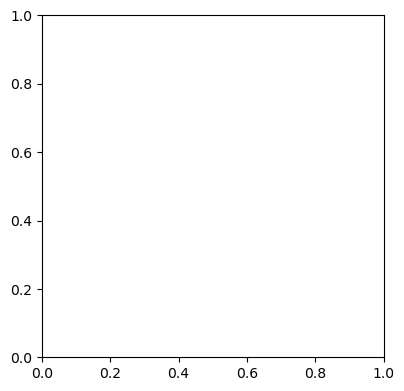

In [32]:
test = pd.read_csv('handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Ways to improve the model 

* Use more training samples. This will help the model to learn and generalise better. I have used only 10% of the images as the entire training set cannot be loaded into kaggle's memory. 
* There are multiple images in the training set which are not at all legible to the human eye. Removing such images will help in model's learning. 

*P.S : This is my first Kaggle notebook. Any feedback would be highly appreciated*